## Import Python Libraries

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import requests
import re
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import seaborn as sns
import klib
import lazypredict
import requests
import scipy.stats

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)


## Webscrapping Our Data Using BeautifulSoup

In [2]:
# Using Carsguide.com.au to webscrappe car price and associatted features.
# In order to scrape accross multiples pages via toggle menu each webpage url differs by ascends in multiples of 12

loop = [x for x in range(18900) if x%12==0] # creating a list of 12 to loop through
base_url = 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=0&searchLimit=12'
pages = requests.get(base_url)
soup = BeautifulSoup(pages.text,'lxml')


In [3]:
# looping through list in order to append each pages url to the new_urls_list
new_urls_list = []
for number in loop:
    new_urls_list.append(base_url.split('set=')[0]+'set='+str(number)+'&searchLimit=12')
new_urls_list

['https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=0&searchLimit=12',
 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=12&searchLimit=12',
 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=24&searchLimit=12',
 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=36&searchLimit=12',
 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=48&searchLimit=12',
 'https://www.carsguide.com.au/buy-a-car/all-new-and-used/qld/all-locations/all-bodytypes/all-makes?distanceFromMe=Brisbane,QLD&searchOffset=60&searchLimit=12',
 'https://www.carsguide.com.au/buy-

In [4]:
# Diving deeper into the individual advertisment requires scraping those links per page
car_link_list = []
for new in new_urls_list: 
    link_pages = requests.get(new)
    link_soup = BeautifulSoup(link_pages.text,'lxml')
    for link in link_soup.find_all('a', attrs={'class': "carListing carListing-slideBtn"}): # Scrapping link
        car_link_list.append('https://www.carsguide.com.au/'+link.get('href')) # Appending each individual add link

In [7]:
# Multiprocessing runs faster as there are over 18000 links to scrape
listing = []
def transform(final_link):
    web_page = requests.get(final_link)
    web_soup = BeautifulSoup(web_page.text,"lxml")
    details = [x.get_text() for x in web_soup.find_all('table',{'class':"details-page-tab-table more-details clearfix"})]
    listing.append(details)
    return

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(transform,car_link_list)
  

## Creating Our Pandas Dataframe and Saving Our Data

In [10]:
df = pd.DataFrame(listing)

# Saving our data so we do not have to scrape again
df.to_csv('CarSales_Scrape.csv',index=False)

In [36]:
# Reading in our saved dataframe and viewing the first 5 rows
df = pd.read_csv('CarSales_Scrape.csv')
df.head(5)

0
0  \n\nPrice\n$18,990                        Calc...
1  \n\nPrice\n$54,990                        Calc...
2  \n\nPrice\n$36,550                        Calc...
3  \n\nPrice\n$10,680                        Calc...
4  \n\nPrice\n$27,990                      \n\n\n...

In [37]:
# This function allows for the creation of columns features while cleaning some dirty syntax associated with scrapping
def clean(df,col,split_on,second_split,column_name):
    df[column_name] = df[col].str.split(split_on).str[1].str.strip()
    df[column_name] = df[column_name].str.split(second_split).str[0].str.strip()
    
# Col in our function is the original 0 column of our dataframe.
# split_on is what we want to split on.
# second_split is what we want our second split to be on.
# column_name is what we want our new column to be named.

## Data Cleaning 

In [38]:
clean(df,'0','Price','Cal','Price')
clean(df,'0','Vehicle','Seller','Vehicle')

clean(df,'0','Body type','Doors','Doors')
clean(df,'0','Doors','Seats','Seats')

clean(df,'0','ext / int','Reg','Colour')
clean(df,'0','Kilometres','Colour','Kilometres')

clean(df,'0','Body type',',','Body')
clean(df,'0','Transmission','Engine','Transmission')

clean(df,'0','Drive type','Fuel type','Drive')
clean(df,'0','Fuel type','Fuel','Fuel_type')

clean(df,'0','Engine','Drive','Engine')
clean(df,'0','consumption','Kilometres','Fuel_consumption')

In [39]:
# We can see that our Price Column is not completely clean
df['Price']

0                                                  $18,990
1                                                  $54,990
2                                                  $36,550
3                                                  $10,680
4        $27,990                      \n\n\nVehicle\n20...
                               ...                        
22473    $43,000                      \n\n\nVehicle\n20...
22474    $63,190                      \n\n\nVehicle\n20...
22475    $39,000                      \n\n\nVehicle\n20...
22476    $45,000                      \n\n\nVehicle\n20...
22477    $84,100                      \n\n\nVehicle\n20...
Name: Price, Length: 22478, dtype: object

In [40]:
# We need to split and strip again
df['Price'] = df['Price'].str.split('\n').str[0].str.strip()
df['Price']

0        $18,990
1        $54,990
2        $36,550
3        $10,680
4        $27,990
          ...   
22473    $43,000
22474    $63,190
22475    $39,000
22476    $45,000
22477    $84,100
Name: Price, Length: 22478, dtype: object

In [41]:
df['Body'] = df['Body'].str.split('\n').str[0].str.strip()

In [42]:
# We have some syntax issues in most columns that need to be replaced
df.head(2)

0    Price  \
0  \n\nPrice\n$18,990                        Calc...  $18,990   
1  \n\nPrice\n$54,990                        Calc...  $54,990   

                                             Vehicle     Doors Seats  \
0                    2012 Ford Falcon XR6 FG Upgrade  Sedan, 4   , 5   
1  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...    SUV, 4   , 7   

       Colour  Kilometres   Body Transmission Drive Fuel_type        Engine  \
0  Silver / -  134,301 km  Sedan    Automatic  Rear  Unleaded    6 cyl, 4 L   
1    Grey / -   79,553 km    SUV    Automatic   4WD    Diesel  4 cyl, 2.8 L   

  Fuel_consumption  
0   9.9 L / 100 km  
1     8 L / 100 km

In [43]:
# Creating a function to replace any punctuation or syntax issues
def replacing(col,syntax,d=''):
    df[col] = df[col].str.replace(syntax,d)

In [44]:
# We want to drop the dollar sign and comma so we can change this data type into an integer
replacing('Price','$') 
replacing('Price',',')

# We want to drop the km and comma so we can change this data type into an integer
replacing('Kilometres','km')
replacing('Kilometres',',')

replacing('Seats',',')
replacing('Fuel_consumption','L / 100 km')

df = df.replace('-',np.nan)

/Users/garethbayvel/Desktop/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# We can see that we have mostly cleaned up our columns but now we want to extract their numeric values only
df

0  Price  \
0      \n\nPrice\n$18,990                        Calc...  18990   
1      \n\nPrice\n$54,990                        Calc...  54990   
2      \n\nPrice\n$36,550                        Calc...  36550   
3      \n\nPrice\n$10,680                        Calc...  10680   
4      \n\nPrice\n$27,990                      \n\n\n...  27990   
...                                                  ...    ...   
22473  \n\nPrice\n$43,000                      \n\n\n...  43000   
22474  \n\nPrice\n$63,190                      \n\n\n...  63190   
22475  \n\nPrice\n$39,000                      \n\n\n...  39000   
22476  \n\nPrice\n$45,000                      \n\n\n...  45000   
22477  \n\nPrice\n$84,100                      \n\n\n...  84100   

                                                 Vehicle            Doors  \
0                        2012 Ford Falcon XR6 FG Upgrade         Sedan, 4   
1      2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...           SUV, 4   
2                  2016 Holden Colorado LS (4X4) RG MY16    Ute / Tray, 4   
3                              2008 Honda Civic VTI MY07         Sedan, 4   
4                       2020 Hyundai I30 Active PD2 MY20     Hatchback, 4   
...                                                  ...              ...   
22473        2021 Hyundai Tucson Elite (AWD) NX4.V1 MY22           SUV, 4   
22474           2021 Ford Transit 410L (RWD) SRW VO MY21  People Mover, 3   
22475        2021 Hyundai Tucson Elite (FWD) NX4.V1 MY22           SUV, 4   
22476        2021 Hyundai Tucson Elite (AWD) NX4.V1 MY22           SUV, 4   
22477    2021 Mercedes-Benz C200 Night Edition C205 MY21         Coupe, 2   

      Seats                                             Colour  \
0         5                                         Silver / -   
1         7                                           Grey / -   
2         5                                         Silver / -   
3         5                                          Brown / -   
4         5                   Polar White / Charcoal and Black   
...     ...                                                ...   
22473     5  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...   
22474    12  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...   
22475     5  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...   
22476     5  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...   
22477     4  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...   

                        Kilometres          Body Transmission  Drive  \
0                          134301          Sedan    Automatic   Rear   
1                           79553            SUV    Automatic    4WD   
2                           71293     Ute / Tray       Manual    4WD   
3                           88621          Sedan    Automatic  Front   
4      23580 \n\n\nCondition\nUsed     Hatchback    Automatic  Front   
...                            ...           ...          ...    ...   
22473                          NaN           SUV    Automatic    AWD   
22474                          NaN  People Mover    Automatic   Rear   
22475                          NaN           SUV    Automatic  Front   
22476                          NaN           SUV    Automatic    AWD   
22477                          NaN         Coupe    Automatic   Rear   

      Fuel_type        Engine  \
0      Unleaded    6 cyl, 4 L   
1        Diesel  4 cyl, 2.8 L   
2        Diesel  4 cyl, 2.8 L   
3      Unleaded  4 cyl, 1.8 L   
4      Unleaded    4 cyl, 2 L   
...         ...           ...   
22473  Unleaded         4 cyl   
22474    Diesel    4 cyl, 2 L   
22475  Unleaded         4 cyl   
22476    Diesel         4 cyl   
22477  Unleaded         4 cyl   

                                        Fuel_consumption  
0                                                   9.9   
1                                                     8   
2                                                   7.9   
3                                 

In [46]:
# This function allows us to extract the numeric values for each column using regular expression
def extracting_numbers(column_name):
    df[column_name] = df[column_name].str.extract('([\d]+)',expand=False).astype(int, errors = 'ignore')

In [47]:
extracting_numbers('Price') # Extracting only the price
extracting_numbers('Fuel_consumption') # Extracting only the fuel consumption integer
extracting_numbers('Doors') # Allows us to drop the Body type and be left with the number of doors only
extracting_numbers('Engine') # We only want the first number denoting cylinders
extracting_numbers('Seats') # Cleaning up any left over text
extracting_numbers('Kilometres') # Cleaning up any left over text


In [48]:
df.head(2)

0  Price  \
0  \n\nPrice\n$18,990                        Calc...  18990   
1  \n\nPrice\n$54,990                        Calc...  54990   

                                             Vehicle Doors Seats      Colour  \
0                    2012 Ford Falcon XR6 FG Upgrade     4     5  Silver / -   
1  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...     4     7    Grey / -   

  Kilometres   Body Transmission Drive Fuel_type Engine Fuel_consumption  
0     134301  Sedan    Automatic  Rear  Unleaded      6                9  
1      79553    SUV    Automatic   4WD    Diesel      4                8

In [49]:
# For our Anlysis we would expect year and price to be corellated so we need to create a year column
df['Year'] = df['Vehicle'].str.split(' ').str[0]

# Droping our 0 columns
df.drop(columns='0',inplace=True)

In [50]:
# Our data is looking failry clean at the moment but our Colour Column still contains syntax errors
df

Price                                            Vehicle Doors Seats  \
0      18990                    2012 Ford Falcon XR6 FG Upgrade     4     5   
1      54990  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...     4     7   
2      36550              2016 Holden Colorado LS (4X4) RG MY16     4     5   
3      10680                          2008 Honda Civic VTI MY07     4     5   
4      27990                   2020 Hyundai I30 Active PD2 MY20     4     5   
...      ...                                                ...   ...   ...   
22473  43000        2021 Hyundai Tucson Elite (AWD) NX4.V1 MY22     4     5   
22474  63190           2021 Ford Transit 410L (RWD) SRW VO MY21     3    12   
22475  39000        2021 Hyundai Tucson Elite (FWD) NX4.V1 MY22     4     5   
22476  45000        2021 Hyundai Tucson Elite (AWD) NX4.V1 MY22     4     5   
22477  84100    2021 Mercedes-Benz C200 Night Edition C205 MY21     2     4   

                                                  Colour Kilometres  \
0                                             Silver / -     134301   
1                                               Grey / -      79553   
2                                             Silver / -      71293   
3                                              Brown / -      88621   
4                       Polar White / Charcoal and Black      23580   
...                                                  ...        ...   
22473  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...        NaN   
22474  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...        NaN   
22475  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...        NaN   
22476  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...        NaN   
22477  - / -\n\n\nWarranty\n5 years / Unlimited km\n\...        NaN   

               Body Transmission  Drive Fuel_type Engine Fuel_consumption  \
0             Sedan    Automatic   Rear  Unleaded      6                9   
1               SUV    Automatic    4WD    Diesel      4                8   
2        Ute / Tray       Manual    4WD    Diesel      4                7   
3             Sedan    Automatic  Front  Unleaded      4                7   
4         Hatchback    Automatic  Front  Unleaded      4                7   
...             ...          ...    ...       ...    ...              ...   
22473           SUV    Automatic    AWD  Unleaded      4                7   
22474  People Mover    Automatic   Rear    Diesel      4                0   
22475           SUV    Automatic  Front  Unleaded      4                8   
22476           SUV    Automatic    AWD    Diesel      4                6   
22477         Coupe    Automatic   Rear  Unleaded      4                7   

       Year  
0      2012  
1      2015  
2      2016  
3      2008  
4      2020  
...     ...  
22473  2021  
22474  2021  
22475  2021  
22476  2021  
22477  2021  

[22478 rows x 13 columns]

In [51]:
df['Colour'].value_counts().head(30)

White / -                                                                3420
- / -\n\n\nWarranty\n5 years / Unlimited km\n\n\nCountry of origin\n-    3030
Silver / -                                                               1410
Grey / -                                                                 1155
- / -\n\n\nWarranty\n3 years / Unlimited km\n\n\nCountry of origin\n-    1012
Blue / -                                                                  953
- / -\n\n\nWarranty\n3 years / 200,000 km\n\n\nCountry of origin\n-       894
Black / -                                                                 871
- / -\n\n\nWarranty\n3 years / 100,000 km\n\n\nCountry of origin\n-       842
Red / -                                                                   769
- / -\n\n\nWarranty\n3 years / 150,000 km\n\n\nCountry of origin\n-       622
White / Black                                                             490
- / -                                                           

In [52]:
df['Colour'] = df['Colour'].str.replace('/ -','').str.strip()#Most of our colours have / - almost as a suffix we need this removed
df['Colour'] = df['Colour'].str.replace('-', 'Unknown')

# Since most of our rows have wording containg specific identifiers we can use these to replace then with Unkowns
df['Colour'] = np.where(df['Colour'].str.contains('\n\n'),'Unknown',df['Colour']) 
df['Colour'] = df['Colour'].str.split('/').str[0].str.strip()

df['Colour'] = df['Colour'].str.lower()# Fix upper or lower case entries

df['Colour'].value_counts()

unknown                                                 9096
white                                                   4790
silver                                                  2074
grey                                                    1721
blue                                                    1419
black                                                   1326
red                                                     1110
green                                                    152
yellow                                                   151
gold                                                     143
orange                                                   126
brown                                                     86
pearl white                                               13
purple                                                    10
beige                                                      9
metallic blue                                              8
champagne               

In [53]:
# We have multicoloured cars for example metalic white which we wont to be unicolour
colour_dict = dict(df['Colour'].value_counts()) 
colour_list = list(colour_dict.keys())[:12]# creating a list of the 12 most popular colours
colour_list

['unknown',
 'white',
 'silver',
 'grey',
 'blue',
 'black',
 'red',
 'green',
 'yellow',
 'gold',
 'orange',
 'brown']

In [54]:
# This function searches for multicoloured cars containing a colour element from our above list and converts it
def color_change(color,column):
    df[column] = np.where(df[column].str.contains(color),color,df[column])

In [55]:
# Running a for loop so we do not have to do use our function 12 seperate times
for x in colour_list:
    color_change(x,'Colour')

In [56]:
# We have significanlty reduced our colours into something more manageable
df['Colour'].value_counts()

unknown                9096
white                  4842
silver                 2096
grey                   1754
blue                   1454
black                  1346
red                    1121
green                   161
yellow                  155
gold                    147
orange                  135
brown                    89
purple                   10
beige                     9
gray                      5
champagne                 5
charcoal                  3
titanium                  3
bronze                    3
liquid beige              2
colour                    2
burgundy                  2
nitrate                   2
blizzard                  2
midnight                  2
denim                     2
emperor                   2
some like it hot          2
charchol                  2
pink                      2
crystal pearl             2
graphite                  2
modern steel              2
sandy taupe               1
sliver                    1
ehite               

## Data Cleaning and Wrangling

In [57]:
# Always look for duplicated data points especially when webscraping data
df[df['Vehicle'] == '2021 Ford Transit 410L (RWD) SRW VO MY21'] # We have clearly duplicated data from our webscraping

Price                                   Vehicle Doors Seats   Colour  \
10546  63190  2021 Ford Transit 410L (RWD) SRW VO MY21     3    12  unknown   
22474  63190  2021 Ford Transit 410L (RWD) SRW VO MY21     3    12  unknown   

      Kilometres          Body Transmission Drive Fuel_type Engine  \
10546        NaN  People Mover    Automatic  Rear    Diesel      4   
22474        NaN  People Mover    Automatic  Rear    Diesel      4   

      Fuel_consumption  Year  
10546                0  2021  
22474                0  2021

In [58]:
# By default drop_duplicates uses all columns we is exactly what we want in this instance
df = df.drop_duplicates()

In [59]:
# We can see that almost half of our data was duplicated and this would have impacted our statistical analysis
# We also need to reset our index as we have 13468 but our index goes up to 18004. We will do this after droping
df


Price                                            Vehicle Doors Seats  \
0      18990                    2012 Ford Falcon XR6 FG Upgrade     4     5   
1      54990  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...     4     7   
2      36550              2016 Holden Colorado LS (4X4) RG MY16     4     5   
3      10680                          2008 Honda Civic VTI MY07     4     5   
4      27990                   2020 Hyundai I30 Active PD2 MY20     4     5   
...      ...                                                ...   ...   ...   
17572    NaN                   2005 Mazda Tribute Limited Sport     4     5   
17697    NaN          2018 Toyota Fortuner Crusade GUN156R MY19     4     7   
17883    NaN              2018 Toyota Yaris Ascent NCP130R MY17     5     5   
17972    NaN             2013 Hyundai Veloster SR Turbo FS MY13     3     4   
18004    NaN                 2015 Toyota Tarago GLI ACR50R MY13     4     8   

       Colour Kilometres        Body Transmission  Drive Fuel_type Engine  \
0      silver     134301       Sedan    Automatic   Rear  Unleaded      6   
1        grey      79553         SUV    Automatic    4WD    Diesel      4   
2      silver      71293  Ute / Tray       Manual    4WD    Diesel      4   
3       brown      88621       Sedan    Automatic  Front  Unleaded      4   
4       white      23580   Hatchback    Automatic  Front  Unleaded      4   
...       ...        ...         ...          ...    ...       ...    ...   
17572  silver     197038         SUV    Automatic    4WD  Unleaded      6   
17697    grey      52704         SUV    Automatic    AWD    Diesel      4   
17883  orange      14117   Hatchback    Automatic  Front  Unleaded      4   
17972     red      69294   Hatchback    Automatic  Front  Unleaded      4   
18004  silver      77021       Wagon    Automatic  Front  Unleaded      4   

      Fuel_consumption  Year  
0                    9  2012  
1                    8  2015  
2                    7  2016  
3                    7  2008  
4                    7  2020  
...                ...   ...  
17572               12  2005  
17697                8  2018  
17883                6  2018  
17972                6  2013  
18004                8  2015  

[13467 rows x 13 columns]

Price               0.014480
Vehicle             0.000074
Doors               0.000074
Seats               0.024876
Colour              0.000000
Kilometres          0.260266
Body                0.000074
Transmission        0.074181
Drive               0.000074
Fuel_type           0.017821
Engine              0.019603
Fuel_consumption    0.070543
Year                0.000074
dtype: float64


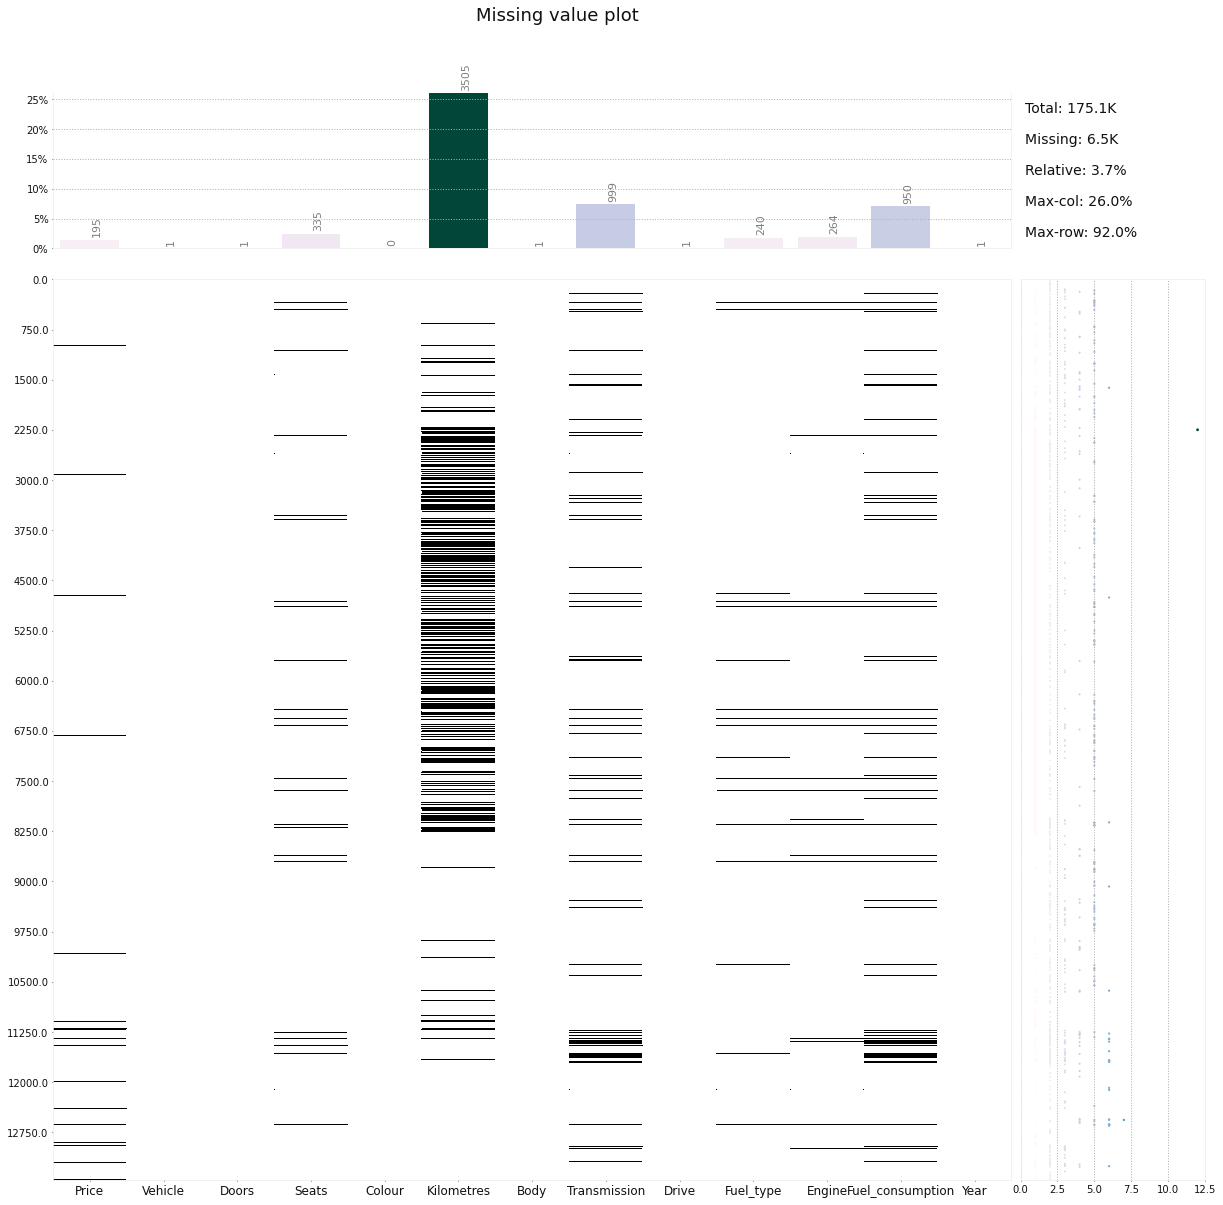

In [60]:
# Looking at the missing values contained in our dataframe
klib.missingval_plot(df)
print(df.isnull().sum()/df.shape[0])

## Rule of Thumb

I normally drop rows that have 1% or 2% missing values in a dataset this size. Notably, we are dropping missing price as it is our dependent variable. We can see that vehicles, doors, colour, body, transmission, drive, fuel_type and year are all missing less than 0.001% of data points. Additionaly, we see corellations between missing values between most columns and as a result we want to drop rows according to a certain threshold of missing values

* We will leave missing KM values as a car with no KM recorded may have a correlation with car price


In [64]:
df[df['Seats'].isnull()].tail()

Price                            Vehicle Doors Seats Colour  \
16031     NaN         2020 Mercedes-Benz A-CLASS    20   NaN   blue   
16041     NaN        2018 Mercedes-Benz Sprinter    18   NaN  white   
16445  149711  2019 Ram 1500 Laramie (No Series)     5   NaN  white   
16525   19711             2012 Ford Ranger XL PX     5   NaN  white   
16705     NaN          2000 Land Rover Discovery   386   NaN    red   

      Kilometres          Body Transmission  Drive Fuel_type Engine  \
16031         20     Hatchback          NaN  Other       NaN    NaN   
16041      18966  People Mover          NaN  Other       NaN    NaN   
16445       9880    Ute / Tray          NaN  Other    Diesel      3   
16525     226091    Ute / Tray          NaN  Other    Diesel      2   
16705     386243         Wagon          NaN  Other       NaN    NaN   

      Fuel_consumption  Year  
16031              NaN  2020  
16041              NaN  2018  
16445              NaN  2019  
16525              NaN  2012  
16705              NaN  2000

In [66]:
df = df.dropna(thresh = 6)

In [67]:
df = df.dropna(subset=['Price','Vehicle','Doors','Colour','Body','Drive','Fuel_type'])
df.reset_index(inplace = True, drop = True) # Resetting our Index
df

Price                                            Vehicle Doors Seats  \
0      18990                    2012 Ford Falcon XR6 FG Upgrade     4     5   
1      54990  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...     4     7   
2      36550              2016 Holden Colorado LS (4X4) RG MY16     4     5   
3      10680                          2008 Honda Civic VTI MY07     4     5   
4      27990                   2020 Hyundai I30 Active PD2 MY20     4     5   
...      ...                                                ...   ...   ...   
13044  40000                   2016 Mazda CX-9 Azami (awd) MY16     4     7   
13045  30995                         2019 Mazda 3 G20 Evolve BP     5     5   
13046  16995                                2014 Mazda 3 NEO BM     5     5   
13047  13995               2014 Ford Focus Trend LW MK2 Upgrade     5     5   
13048  10990                     2012 Mazda 3 NEO BL 11 Upgrade     4     5   

       Colour Kilometres        Body Transmission  Drive Fuel_type Engine  \
0      silver     134301       Sedan    Automatic   Rear  Unleaded      6   
1        grey      79553         SUV    Automatic    4WD    Diesel      4   
2      silver      71293  Ute / Tray       Manual    4WD    Diesel      4   
3       brown      88621       Sedan    Automatic  Front  Unleaded      4   
4       white      23580   Hatchback    Automatic  Front  Unleaded      4   
...       ...        ...         ...          ...    ...       ...    ...   
13044    grey     142433         SUV    Automatic    AWD  Unleaded      4   
13045     red       8623   Hatchback    Automatic  Front  Unleaded      4   
13046     red      38381   Hatchback    Automatic  Front  Unleaded      4   
13047   black      55050   Hatchback    Automatic  Front  Unleaded      4   
13048   white     126328       Sedan       Manual  Front  Unleaded      4   

      Fuel_consumption  Year  
0                    9  2012  
1                    8  2015  
2                    7  2016  
3                    7  2008  
4                    7  2020  
...                ...   ...  
13044                8  2016  
13045                6  2019  
13046                5  2014  
13047                6  2014  
13048                7  2012  

[13049 rows x 13 columns]

Price               0.000000
Vehicle             0.000000
Doors               0.000000
Seats               0.010882
Colour              0.000000
Kilometres          0.265538
Body                0.000000
Transmission        0.057782
Drive               0.000000
Fuel_type           0.000000
Engine              0.006514
Fuel_consumption    0.052341
Year                0.000000
dtype: float64


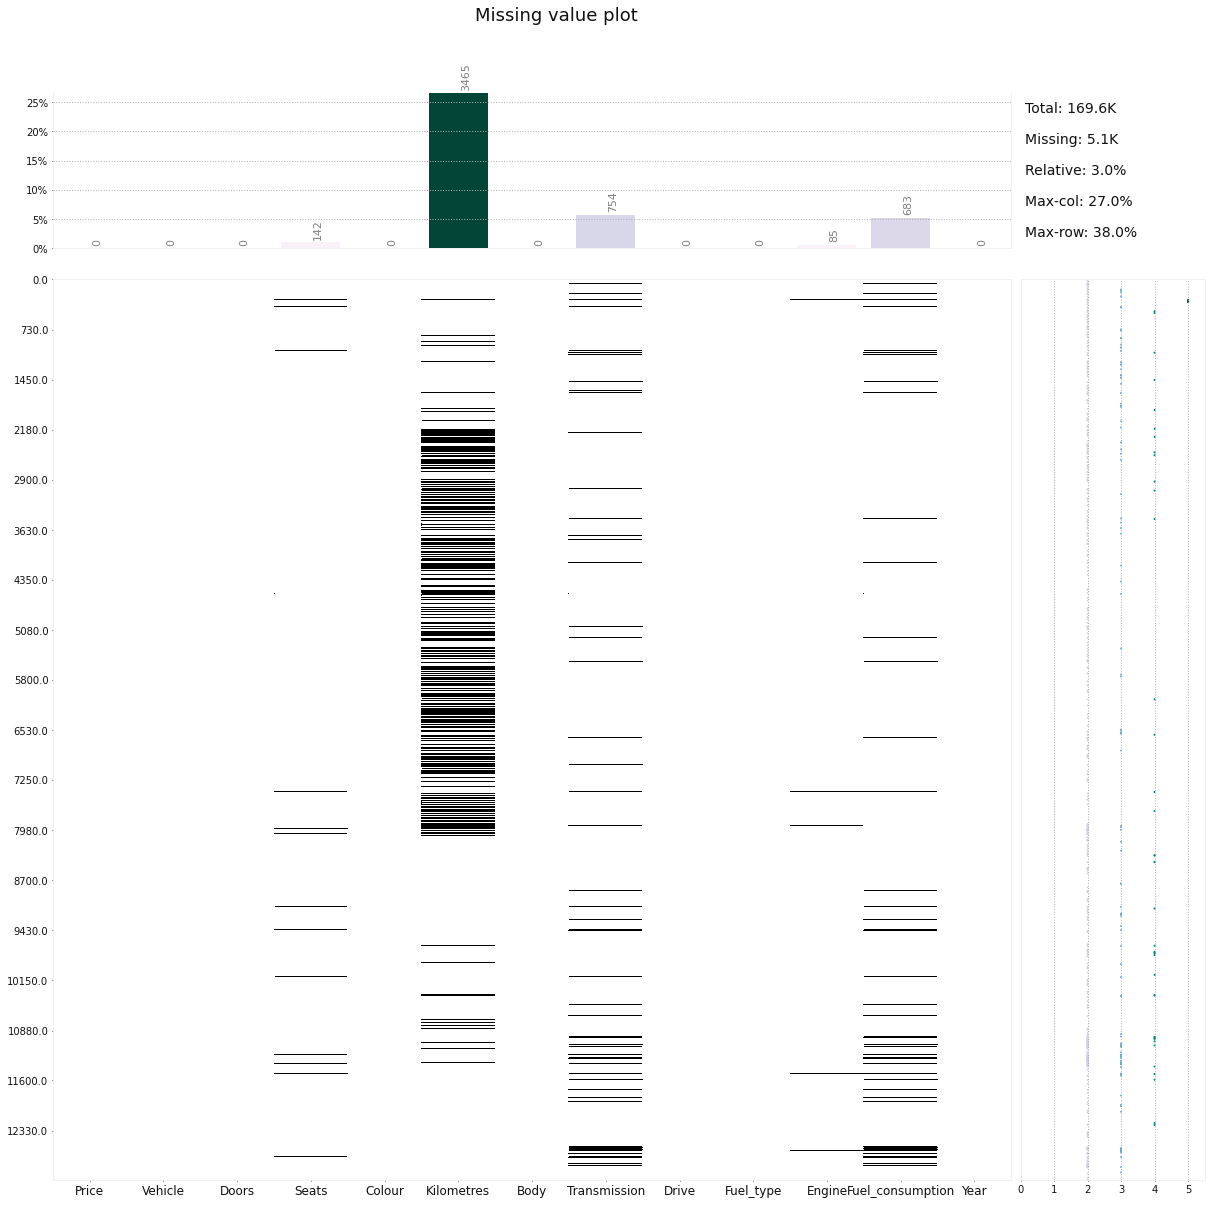

In [68]:
# Looking at the missing values contained in our dataframe
klib.missingval_plot(df)
print(df.isnull().sum()/df.shape[0])

In [70]:
# Seats and Engine now only have below 0.01% missing values
df = df.dropna(subset=['Seats','Engine'])
df.reset_index(inplace = True, drop = True) # Resetting our Index
df

Price                                            Vehicle Doors Seats  \
0      18990                    2012 Ford Falcon XR6 FG Upgrade     4     5   
1      54990  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...     4     7   
2      36550              2016 Holden Colorado LS (4X4) RG MY16     4     5   
3      10680                          2008 Honda Civic VTI MY07     4     5   
4      27990                   2020 Hyundai I30 Active PD2 MY20     4     5   
...      ...                                                ...   ...   ...   
12856  40000                   2016 Mazda CX-9 Azami (awd) MY16     4     7   
12857  30995                         2019 Mazda 3 G20 Evolve BP     5     5   
12858  16995                                2014 Mazda 3 NEO BM     5     5   
12859  13995               2014 Ford Focus Trend LW MK2 Upgrade     5     5   
12860  10990                     2012 Mazda 3 NEO BL 11 Upgrade     4     5   

       Colour Kilometres        Body Transmission  Drive Fuel_type Engine  \
0      silver     134301       Sedan    Automatic   Rear  Unleaded      6   
1        grey      79553         SUV    Automatic    4WD    Diesel      4   
2      silver      71293  Ute / Tray       Manual    4WD    Diesel      4   
3       brown      88621       Sedan    Automatic  Front  Unleaded      4   
4       white      23580   Hatchback    Automatic  Front  Unleaded      4   
...       ...        ...         ...          ...    ...       ...    ...   
12856    grey     142433         SUV    Automatic    AWD  Unleaded      4   
12857     red       8623   Hatchback    Automatic  Front  Unleaded      4   
12858     red      38381   Hatchback    Automatic  Front  Unleaded      4   
12859   black      55050   Hatchback    Automatic  Front  Unleaded      4   
12860   white     126328       Sedan       Manual  Front  Unleaded      4   

      Fuel_consumption  Year  
0                    9  2012  
1                    8  2015  
2                    7  2016  
3                    7  2008  
4                    7  2020  
...                ...   ...  
12856                8  2016  
12857                6  2019  
12858                5  2014  
12859                6  2014  
12860                7  2012  

[12861 rows x 13 columns]

In [72]:
print(df.isnull().sum()/df.shape[0])

Price               0.000000
Vehicle             0.000000
Doors               0.000000
Seats               0.000000
Colour              0.000000
Kilometres          0.266076
Body                0.000000
Transmission        0.046886
Drive               0.000000
Fuel_type           0.000000
Engine              0.000000
Fuel_consumption    0.041521
Year                0.000000
dtype: float64


## Correcting Our Data Types

Through this process we will unvail any discrepancies within rows, for example letters in price or seat numbers etc

In [73]:
# Checking our data types
# Price, Doors, Seats, Kilometres, Engine and Fuel_consumption can be turned into integers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12861 entries, 0 to 12860
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             12861 non-null  object
 1   Vehicle           12861 non-null  object
 2   Doors             12861 non-null  object
 3   Seats             12861 non-null  object
 4   Colour            12861 non-null  object
 5   Kilometres        9439 non-null   object
 6   Body              12861 non-null  object
 7   Transmission      12258 non-null  object
 8   Drive             12861 non-null  object
 9   Fuel_type         12861 non-null  object
 10  Engine            12861 non-null  object
 11  Fuel_consumption  12327 non-null  object
 12  Year              12861 non-null  object
dtypes: object(13)
memory usage: 1.3+ MB


In [74]:
df1 = df.copy()

In [75]:
df1['Price'] = pd.to_numeric(df1['Price'])
df1['Doors'] = pd.to_numeric(df1['Doors'])
df1['Seats'] = pd.to_numeric(df1['Seats'])
df1['Kilometres'] = pd.to_numeric(df1['Kilometres'])
df1['Engine'] = pd.to_numeric(df1['Engine'])
df1['Fuel_consumption'] = pd.to_numeric(df1['Fuel_consumption'])
df1['Year'] = pd.to_numeric(df1['Year'])

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12861 entries, 0 to 12860
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             12861 non-null  int64  
 1   Vehicle           12861 non-null  object 
 2   Doors             12861 non-null  int64  
 3   Seats             12861 non-null  int64  
 4   Colour            12861 non-null  object 
 5   Kilometres        9439 non-null   float64
 6   Body              12861 non-null  object 
 7   Transmission      12258 non-null  object 
 8   Drive             12861 non-null  object 
 9   Fuel_type         12861 non-null  object 
 10  Engine            12861 non-null  int64  
 11  Fuel_consumption  12327 non-null  float64
 12  Year              12861 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 1.3+ MB


## Exploratory Data Analysis

We will start with our quantitative independent variables:
- **Univariate Analysis** (Shape, Distribution, skewness, Transformation)
- **Bivaraite Analysis** (Correlation with Price)

### Price Statistical Plots

We expect this to be very right skewed as luxury cars are contained within this dataset and are in excess of $200,000

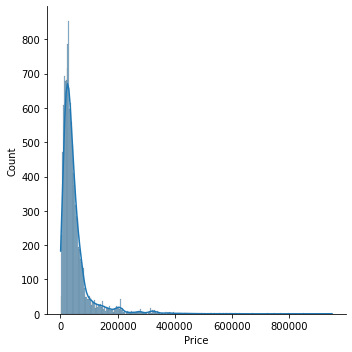

In [120]:
sns.displot(df1['Price'],kde = True)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Price', ylabel='Density'>

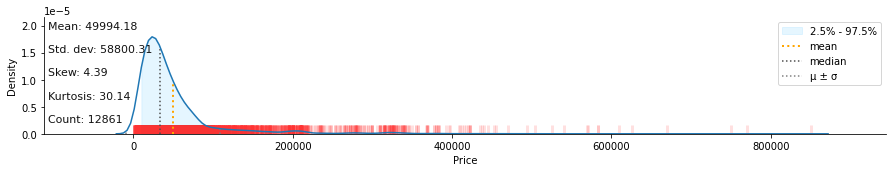

In [92]:
klib.dist_plot(df1['Price'])

##### Our plots and Skewness statistic over 1 indicates it is heavilty right skewed. We may have to transform price to make it more normally distributed

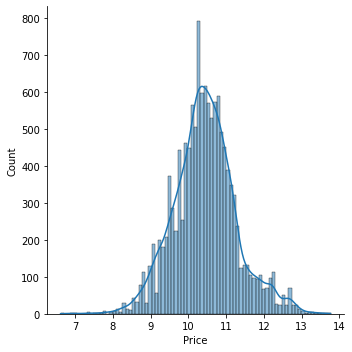

In [126]:
sns.displot(np.log(df1['Price']),kde = True)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Price', ylabel='Density'>

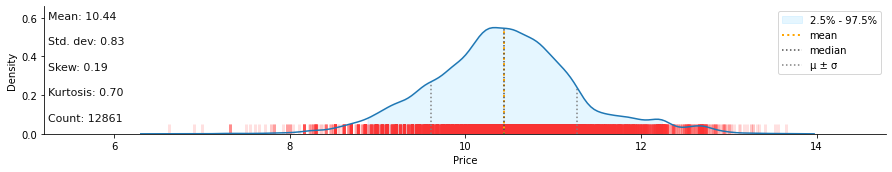

In [127]:
klib.dist_plot(np.log(df1['Price']))

##### Log transforming Price has created a more Normally Distributed distribution (failry symmetric) evidenced by a skewness <1

### Kilometers Statistical Plots

We expect this to be very right skewed as cars within our dataset date back all the way to 1960 so we are expecting some very high numbers

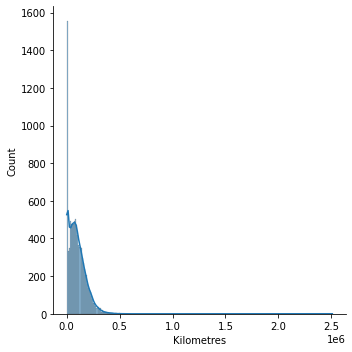

In [162]:
sns.displot(df1['Kilometres'],kde = True)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Kilometres', ylabel='Density'>

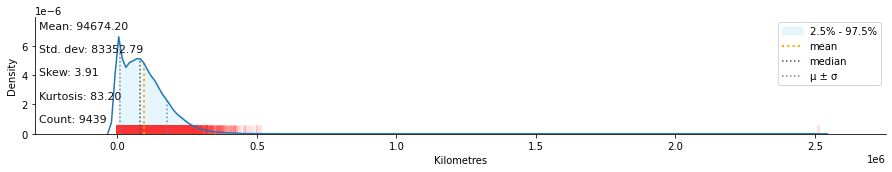

In [163]:
klib.dist_plot(df1['Kilometres'])

##### Our plots and Skewness statistic over 1 indicates it is heavilty right skewed. We may have to transform price to make it more normally distributed

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Kilometres', ylabel='Density'>

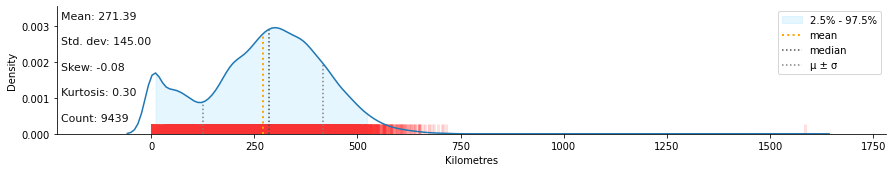

In [165]:
klib.dist_plot(np.sqrt(df1['Kilometres']))

##### Log transforming Price has created a more Normally Distributed distribution (failry symmetric) evidenced by a skewness <1


### Year Statistical Plots

It makes more sense to convert this into how old the car is (AGE)

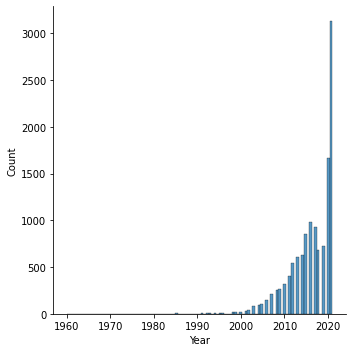

In [242]:
# This is clearly left skewed
sns.displot(df1['Year'])

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='Year', ylabel='Density'>

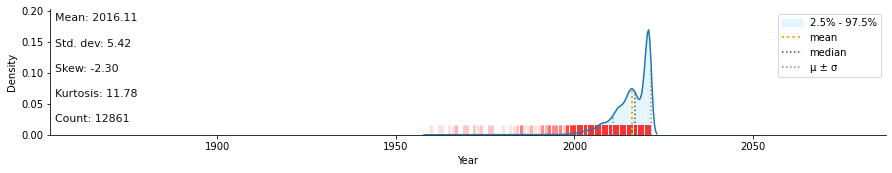

In [244]:
# Our skewness statistic confirms our left skew
# A Kurtosis greater than 3 indicates our data is heavily left tailed
klib.dist_plot(df1['Year'])

In [246]:
# Creating an Age column and shifting our data to be able to perform transformations and you cannot log/sqrt a negative
df1['age'] = 2021 - df1['Year'] +1

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='age', ylabel='Density'>

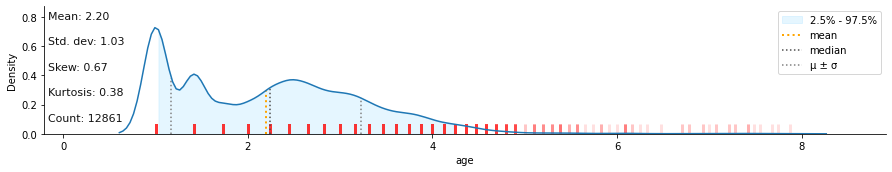

In [253]:
klib.dist_plot(np.sqrt(df1['age']))

##### Log transforming Age has created a more Normally Distributed distribution (failry symmetric) evidenced by a skewness <1

### Considering a Box Cox Transformation for these columns

Lambda value used for Transformation: -0.06117475197288092
Lambda value used for Transformation: 8.472135811722177


/Users/garethbayvel/Desktop/Anaconda3/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/garethbayvel/Desktop/Anaconda3/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


Lambda value used for Transformation: 46.81163473446615


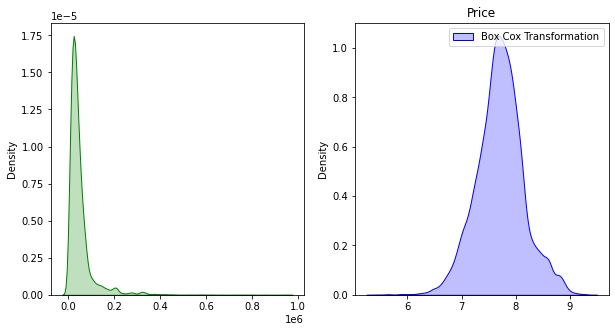

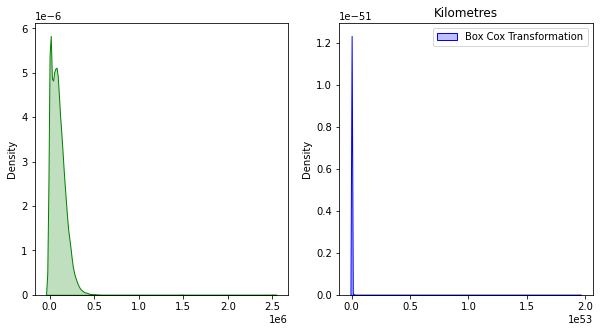

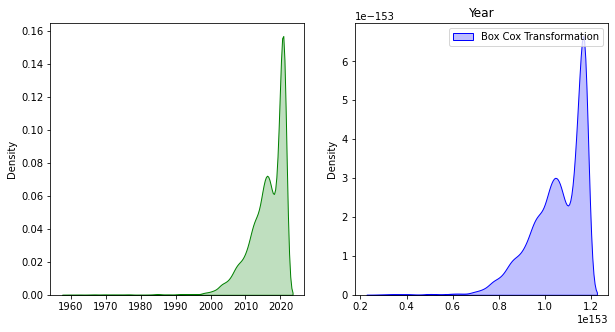

In [273]:
box_cox_data = df1[['Price','Kilometres','Year']]

for x in box_cox_data.columns:
    # generate non-normal data (exponential)
    original_data = df1[x].values
  
    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(original_data)
  
    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)
  
    # plotting the original data(non-normal) and 
    # fitted data (normal)
    sns.kdeplot(original_data, label = "Non-Normal", color ="green", ax = ax[0], fill = True)
    
    sns.kdeplot(fitted_data, label = "Box Cox Transformation", color ="blue", ax = ax[1],fill = True)
  
    # adding legends to the subplots
    plt.legend()
    plt.title(x)
  
    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
  
    print(f"Lambda value used for Transformation: {fitted_lambda}")

##### I think our transformations have achieved a failry symmetrical distribution and a Box Cox does not seem to achive this

In [274]:
# Creating our normally distributed Price, Kilometers and Age
df1['Log_price'] = np.log(df1['Price'])
df1['Sqrt_km'] = np.sqrt(df1['Kilometres'])
df1['Sqrt_age'] = np.sqrt(df1['age'])

In [275]:
df_transformed = df1.drop(['Price','Kilometres','age','Year'],axis=1)
df_transformed.head()

Vehicle  Doors  Seats  Colour  \
0                    2012 Ford Falcon XR6 FG Upgrade      4      5  silver   
1  2015 Toyota Landcruiser Prado GXL (4X4) GDJ150...      4      7    grey   
2              2016 Holden Colorado LS (4X4) RG MY16      4      5  silver   
3                          2008 Honda Civic VTI MY07      4      5   brown   
4                   2020 Hyundai I30 Active PD2 MY20      4      5   white   

         Body Transmission  Drive Fuel_type  Engine  Fuel_consumption  \
0       Sedan    Automatic   Rear  Unleaded       6               9.0   
1         SUV    Automatic    4WD    Diesel       4               8.0   
2  Ute / Tray       Manual    4WD    Diesel       4               7.0   
3       Sedan    Automatic  Front  Unleaded       4               7.0   
4   Hatchback    Automatic  Front  Unleaded       4               7.0   

   Log_price     Sqrt_km  Sqrt_age  
0   9.851668  366.471008  3.162278  
1  10.914907  282.051414  2.645751  
2  10.506436  267.007491  2.449490  
3   9.276128  297.692795  3.741657  
4  10.239603  153.557807  1.414214

In [276]:
klib.corr_mat(df_transformed)

<AxesSubplot:>

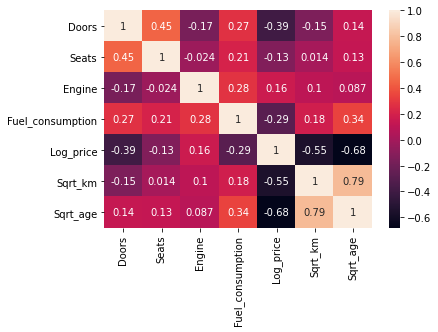

In [277]:
sns.heatmap(df_transformed.corr(),annot = True)